In [23]:
import tensorflow.compat.v1 as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_graph(frozen_graph_filename):
    """
    Args:
        frozen_graph_filename (str): Full path to the .pb file.
    """
    # We load the protobuf file from the disk and parse it to retrieve the
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
        return graph


In [92]:
def segment(graph, image, size=(513,513)):
    """
    Does the segmentation on the given image.
    Args:
        graph (Tensorflow Graph)
        image_file (str): Full path to your image
    Returns:
        segmentation_mask (np.array): The segmentation mask of the image.
    """
    # We access the input and output nodes
    x = graph.get_tensor_by_name('prefix/ImageTensor:0')
    y = graph.get_tensor_by_name('prefix/SemanticPredictions:0')

    # We launch a Session
    with tf.Session(graph=graph) as sess:

        image = image.resize(size)
        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis=0)

        # Note: we don't nee to initialize/restore anything
        # There is no Variables in this graph, only hardcoded constants
        pred = sess.run(y, feed_dict={x: image_array})

        pred = pred.squeeze()

    return pred

In [5]:
def get_n_rgb_colors(n):
    """
    Get n evenly spaced RGB colors.
    Returns:
        rgb_colors (list): List of RGB colors.
    """
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]

    rgb_colors = [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

    return rgb_colors

In [6]:
def parse_pred(pred, n_classes):
    """
    Parses a prediction and returns the prediction as a PIL.Image.
    Args:
        pred (np.array)
    Returns:
        parsed_pred (PIL.Image): Parsed prediction that we can view as an image.
    """
    uni = np.unique(pred)

    empty = np.empty((pred.shape[1], pred.shape[0], 3))

    colors = get_n_rgb_colors(n_classes)

    for i, u in enumerate(uni):
        idx = np.transpose((pred == u).nonzero())
        c = colors[u]
        empty[idx[:,0], idx[:,1]] = [c[0],c[1],c[2]]

    parsed_pred = np.array(empty, dtype=np.uint8)
    parsed_pred = Image.fromarray(parsed_pred)

    return parsed_pred

In [114]:
N_CLASSES = 200 #THE NUMBER OF CLASSES YOUR MODEL HAS
# MODEL_FILE = 'deeplabv3_xception_ade20k_train/frozen_inference_graph.pb'
MODEL_FILE = 'deeplab_xception71_cityscapes/frozen_inference_graph.pb'
IMAGE_FILE = '/home/rus/Desktop/example_images/example_01.png'
INPUT_SIZE = (513, 513)

graph = load_graph(MODEL_FILE)
prediction = segment(graph, Image.open(IMAGE_FILE), INPUT_SIZE)
segmented_image = parse_pred(prediction, N_CLASSES)

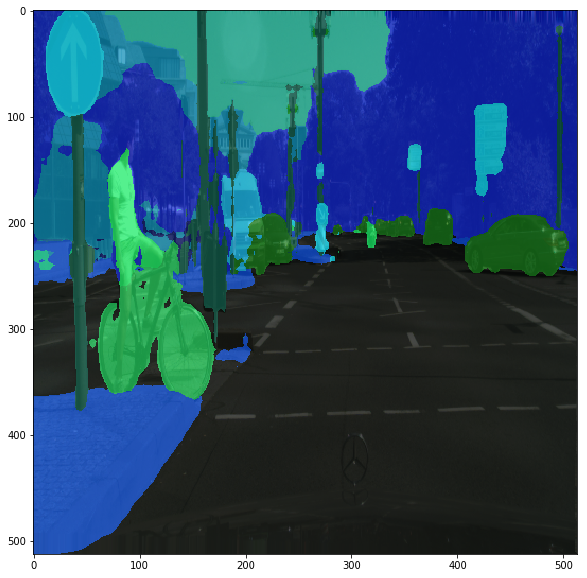

In [115]:
original = Image.open(IMAGE_FILE).resize((513, 513))
output = ((0.3 * np.array(original)) + (0.7 * np.array(segmented_image))).astype("uint8")

plt.figure(figsize=(10,10))
plt.imshow(output);

In [116]:
np.array(segmented_image).shape

(513, 513, 3)

In [117]:
prediction.shape, np.unique(prediction)

((513, 513),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 18]))

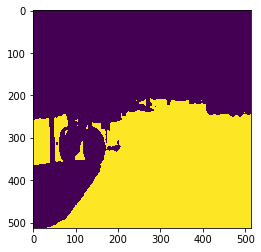

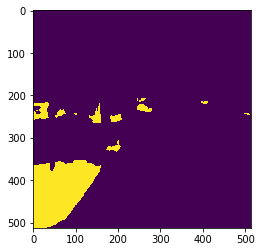

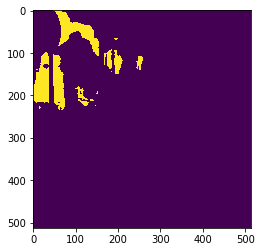

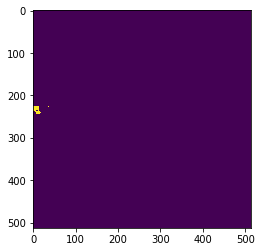

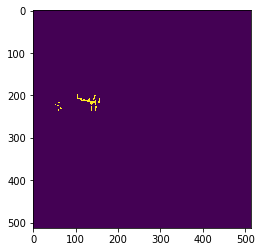

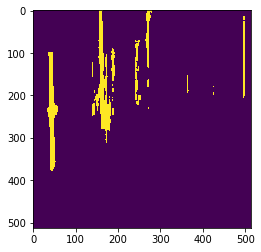

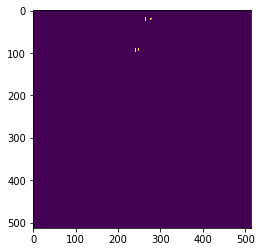

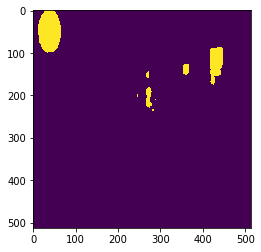

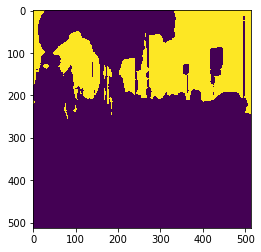

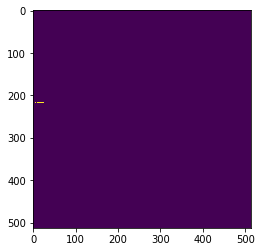

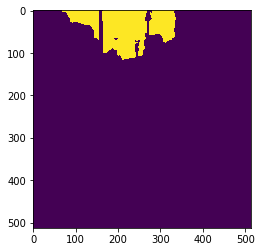

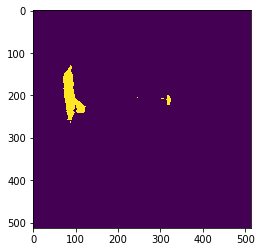

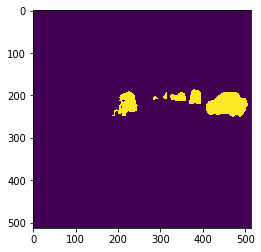

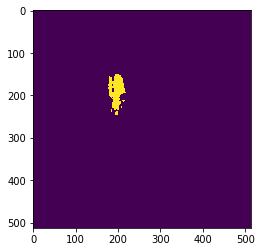

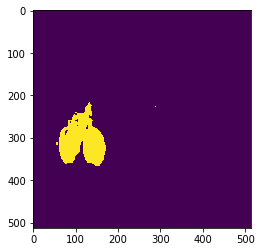

In [118]:
for label in np.unique(prediction):
    plt.imshow(prediction==label)
    plt.show()

## Get frames from our video to test models

In [59]:
import cv2
import imutils

vs = cv2.VideoCapture('/media/rus/Share_data/Documents/Deep_learning_Computer_Vision/realsense_recordings/way_forward.avi')

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))

    # an error occurred while trying to determine the total
    # number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1
    
frames = []
for i in range(total):
    ret, frame = vs.read()
    if ret and i%3000==0:
        print('[INFO]: added frame number {}'.format(i))
        frames.append(frame)


[INFO] 21654 total frames in video
[INFO]: added frame number 0
[INFO]: added frame number 3000
[INFO]: added frame number 6000
[INFO]: added frame number 9000
[INFO]: added frame number 12000
[INFO]: added frame number 15000
[INFO]: added frame number 18000
[INFO]: added frame number 21000


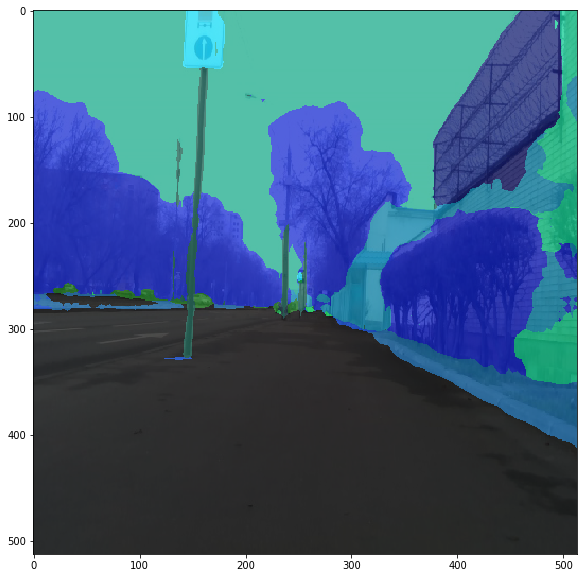

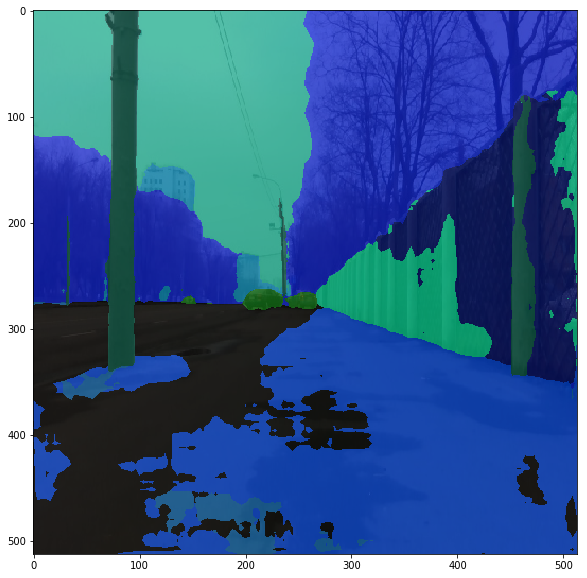

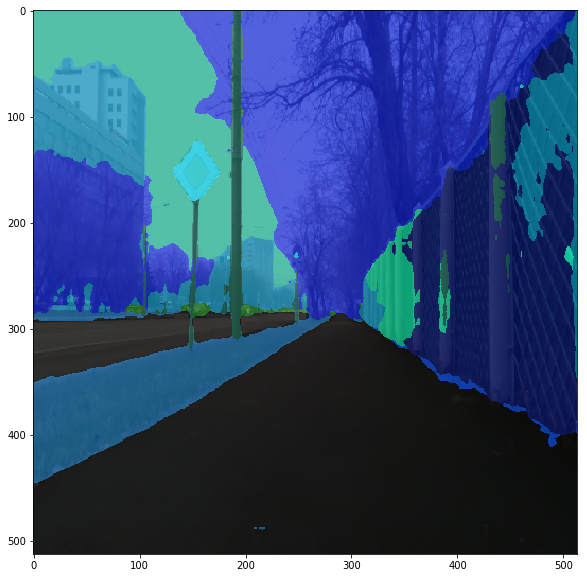

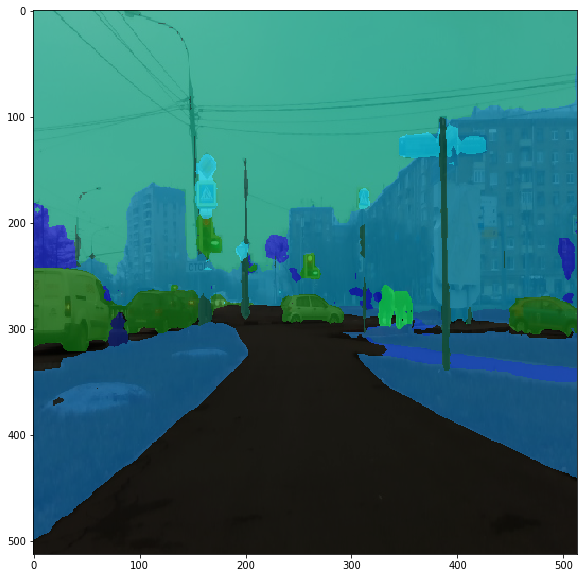

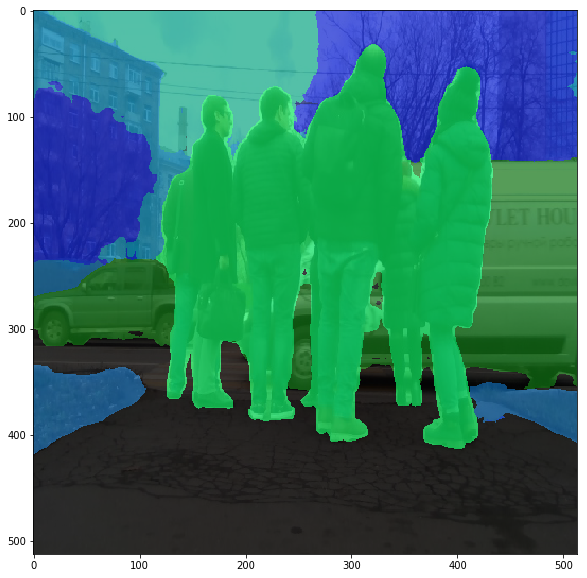

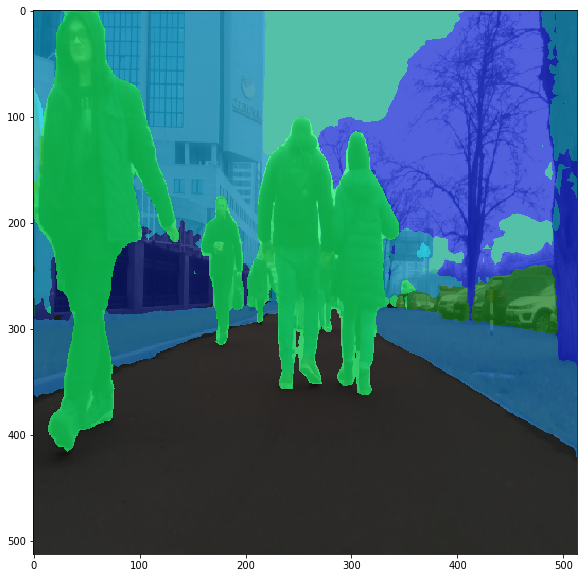

In [119]:
for frame in frames[:-2]:
    original = frame[:,:,(2,1,0)]
    pil_frame = Image.fromarray(np.uint8(original))
    prediction = segment(graph, pil_frame)
    segmented_image = parse_pred(prediction, N_CLASSES)
    
    output = (0.3 * np.array(pil_frame.resize(INPUT_SIZE)) + (0.7 * np.array(segmented_image))).astype("uint8")
    
    plt.figure(figsize=(10,10))
    plt.imshow(output);